In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from IPython.display import display
from matplotlib import pyplot as plt

DIR_INPUT = '/home/arti/DL/Projects/Detection/[Det] Faster-RCN - Face Detection/Data'
DIR_TRAIN = f'{DIR_INPUT}/train'
lable_path_train = f'{DIR_INPUT}/train/_annotations.txt'

In [2]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

num_classes = file_len('Data/train/_classes.txt')
num_classes

2

In [3]:
def read_yolov4_format_as_df(lable_path):
    truth = {}
    f = open(lable_path, 'r', encoding='utf-8')
    for line in f.readlines():
        data = line.split(" ")
        truth[data[0]] = []
        for i in data[1:]:
            truth[data[0]].append([int(j) for j in i.split(',')])

    data = truth.items()
    data = np.array(list(data))
    df = pd.DataFrame(data)
    return df

In [4]:
train_df = read_yolov4_format_as_df(lable_path_train)
train_df = train_df.explode([1]).reset_index(drop=True)

In [5]:
train_df.columns = ['image_id', 'bbox']

train_df.bbox = train_df.bbox.astype(str)

In [6]:
cd Data/train/

/home/arti/DL/Projects/Detection/[Det] Faster-RCN - Face Detection/Data/train


In [7]:
# drop not_existing values

# cd Data/train/
names = glob.glob("*.jpg")
train_df = train_df.assign(exists=0)
train_df.loc[train_df.image_id.isin(names), 'exists'] = 1

train_df = train_df[train_df.exists==1]
train_df = train_df.drop('exists', axis=1)

In [8]:
train_df['x1'] = -1
train_df['y1'] = -1
train_df['x2'] = -1
train_df['y2'] = -1
train_df['cls'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1, -1]
    return r

train_df[['x1', 'y1', 'x2', 'y2', 'cls']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x1'] = train_df['x1'].astype(np.float)
train_df['y1'] = train_df['y1'].astype(np.float)
train_df['x2'] = train_df['x2'].astype(np.float)
train_df['y2'] = train_df['y2'].astype(np.float)
train_df['cls'] = train_df['cls'].astype(np.float)

In [9]:
train_df.cls = 1

In [10]:
train_df['width'] = 640
train_df['height'] = 640

In [11]:
train_df

,image_id,x1,y1,x2,y2,cls,width,height
0,2012-09-28_15_36_23_jpg.rf.000034457db99ab6d49...,139.0,165.0,162.0,205.0,1,640,640
1,2012-09-28_15_36_23_jpg.rf.000034457db99ab6d49...,155.0,165.0,177.0,207.0,1,640,640
2,2012-09-28_15_36_23_jpg.rf.000034457db99ab6d49...,172.0,165.0,194.0,207.0,1,640,640
3,2012-09-28_15_36_23_jpg.rf.000034457db99ab6d49...,188.0,164.0,211.0,206.0,1,640,640
4,2012-09-28_15_36_23_jpg.rf.000034457db99ab6d49...,204.0,166.0,226.0,206.0,1,640,640
...,...,...,...,...,...,...,...,...
498040,2012-10-14_06_19_36_jpg.rf.354a768d4d21d391297...,204.0,448.0,238.0,499.0,1,640,640
498041,2012-10-14_06_19_36_jpg.rf.354a768d4d21d391297...,231.0,451.0,264.0,504.0,1,640,640
498042,2012-10-14_06_19_36_jpg.rf.354a768d4d21d391297...,259.0,448.0,291.0,500.0,1,640,640
498043,2012-10-14_06_19_36_jpg.rf.354a768d4d21d391297...,288.0,449.0,314.0,504.0,1,640,640


In [12]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-1500:]
train_ids = image_ids[:-1500]

valid_ids.shape, train_ids.shape

((1500,), (7002,))

In [13]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [14]:
train_df.shape, valid_df.shape

((411084, 8), (86772, 8))

In [15]:
train_df

,image_id,x1,y1,x2,y2,cls,width,height
0,2012-09-28_15_36_23_jpg.rf.000034457db99ab6d49...,139.0,165.0,162.0,205.0,1,640,640
1,2012-09-28_15_36_23_jpg.rf.000034457db99ab6d49...,155.0,165.0,177.0,207.0,1,640,640
2,2012-09-28_15_36_23_jpg.rf.000034457db99ab6d49...,172.0,165.0,194.0,207.0,1,640,640
3,2012-09-28_15_36_23_jpg.rf.000034457db99ab6d49...,188.0,164.0,211.0,206.0,1,640,640
4,2012-09-28_15_36_23_jpg.rf.000034457db99ab6d49...,204.0,166.0,226.0,206.0,1,640,640
...,...,...,...,...,...,...,...,...
411230,2013-01-18_17_10_13_jpg.rf.09094fd613a14ce4c72...,108.0,206.0,152.0,279.0,1,640,640
411231,2013-01-18_17_10_13_jpg.rf.09094fd613a14ce4c72...,137.0,186.0,179.0,244.0,1,640,640
411232,2013-01-18_17_10_13_jpg.rf.09094fd613a14ce4c72...,162.0,159.0,198.0,213.0,1,640,640
411233,2013-01-18_17_10_13_jpg.rf.09094fd613a14ce4c72...,183.0,138.0,219.0,188.0,1,640,640


In [16]:
class PKLotDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x1', 'y1', 'x2', 'y2']].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [17]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1.0),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Create the model

In [18]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [19]:
num_classes = 2  # 1 class (car) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [20]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [21]:
DIR_TRAIN

'/home/arti/DL/Projects/Detection/[Det] Faster-RCN - Face Detection/Data/train'

In [22]:
train_dataset = PKLotDataset(train_df, DIR_TRAIN, get_train_transform())


In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = PKLotDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = PKLotDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [24]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

# Sample

In [25]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [26]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


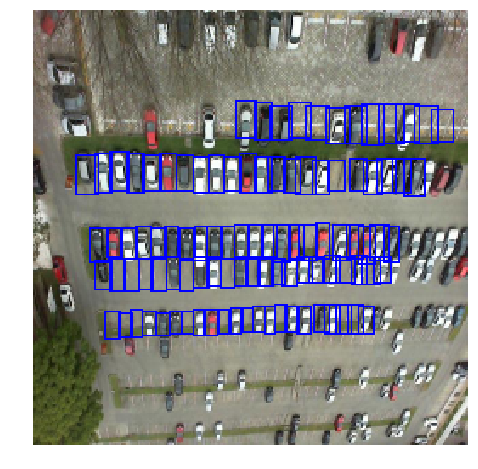

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 0, 120), 1)
    
ax.set_axis_off()
ax.imshow(sample)

# Train

In [32]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 1

In [33]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # model class can takes 2 params and return loss_dict
        # also can do : outputs = model(images)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


        if itr % 100 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Iteration #100 loss: 0.30950403213500977
Iteration #200 loss: 0.43294674158096313
Iteration #300 loss: 0.24323216080665588
Iteration #400 loss: 0.2905164957046509
Iteration #500 loss: 0.2193845808506012
Iteration #600 loss: 0.13708893954753876
Iteration #700 loss: 0.19685649871826172
Iteration #800 loss: 0.1289101243019104
Iteration #900 loss: 0.20509105920791626
Iteration #1000 loss: 0.14133688807487488
Iteration #1100 loss: 0.1498592495918274
Iteration #1200 loss: 0.1486389935016632
Iteration #1300 loss: 0.11475282907485962
Iteration #1400 loss: 0.12748129665851593
Iteration #1500 loss: 0.12127873301506042
Iteration #1600 loss: 0.08932267129421234
Iteration #1700 loss: 0.11248809099197388
Epoch #0 loss: 0.18735469950055614


# Results

In [99]:
it = iter(valid_data_loader)
images, targets, image_ids = next(it)
images, targets, image_ids = next(it)

In [100]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [101]:
boxes = targets[3]['boxes'].cpu().numpy().astype(np.int32)
sample = images[3].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


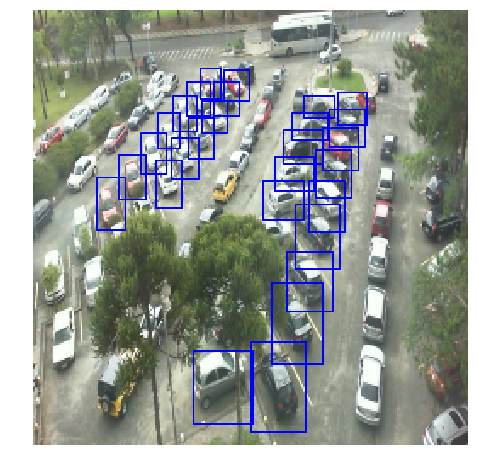

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 0, 220), 1)
    
ax.set_axis_off()
ax.imshow(sample)

### pred boxes

In [87]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [88]:
boxes = outputs[3]['boxes'].detach().cpu().numpy().astype(np.int32)
sample = images[3].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


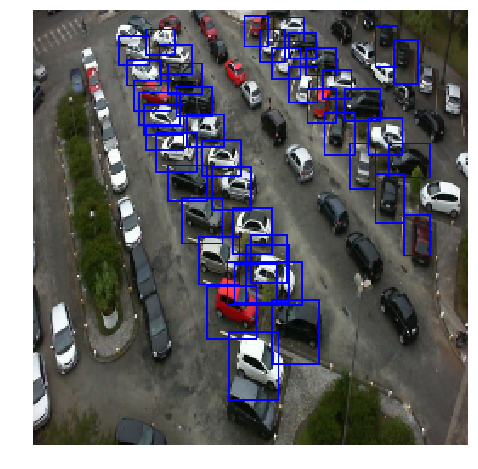

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 0, 120), 1)
    
ax.set_axis_off()
ax.imshow(sample)

### Set threshold to 0.8

In [92]:
boxes = outputs[3]['boxes'].detach().cpu().numpy().astype(np.int32)
scores = outputs[3]['scores'].detach().cpu().numpy().astype(np.float)
indexes = np.where(scores > 0.6)[0]
boxes = boxes[indexes]    
sample = images[3].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


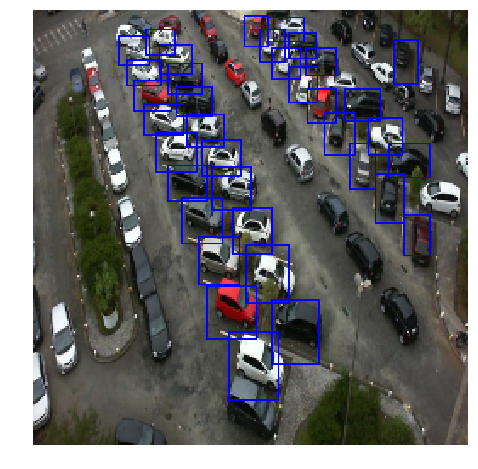

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 0, 220), 1)
    
ax.set_axis_off()
ax.imshow(sample)

# Save

In [94]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')